In [1]:
import mars_troughs as mt
import os
import numpy as np
from mars_troughs import DATAPATHS, Model
from mars_troughs.datapaths import (
                                    load_insolation_data,
                                    load_obliquity_data,
                                    load_retreat_data)
from mars_troughs.custom_lag_models import (ConstantLag,
                                            LinearLag,
                                            QuadraticLag,
                                            CubicLag,
                                            PowerLawLag)
from mars_troughs.custom_acc_models import (Linear_Obliquity,
                                            Quadratic_Obliquity,
                                            Cubic_Obliquity,
                                            PowerLaw_Obliquity,
                                            Linear_Insolation,
                                            Quadratic_Insolation,
                                            Cubic_Insolation,
                                            PowerLaw_Insolation)
from mars_troughs import MCMC
import pickle
import matplotlib.pyplot as plt
import corner

accModel_ins_dict= { 1: Linear_Insolation,
                     2: Quadratic_Insolation,
                     3: Cubic_Insolation,
                     4: PowerLaw_Insolation }

accModel_obl_dict= { 1: Linear_Obliquity,
                     2: Quadratic_Obliquity,
                     3: Cubic_Obliquity,
                     4: PowerLaw_Obliquity }

lagModel_dict= {  1: ConstantLag,
                  2: LinearLag,
                  3: QuadraticLag,
                  4: CubicLag,
                  5: PowerLawLag }


In [35]:
tmp=1
acc=4
lag=2
data='insolation'
maxSteps=200
dir='../../outputMCMC/'
thin_by=10

#if data is insolation,load insolation data
if data=="insolation":
    (insolations,ins_times) = load_insolation_data(tmp)
    times=-ins_times.astype(float)
    times[0]=1e-10
    acc_model=accModel_ins_dict[acc](times,insolations)
else:
    (obliquity,obl_times) = load_obliquity_data()
    times=-obl_times.astype(float)
    times[0]=1e-10
    acc_model=accModel_obl_dict[acc](times, obliquity)
    
lag_model=lagModel_dict[lag]()
directory= (dir + data + '/TMP' + str(tmp) + '/')
errorbar=np.sqrt(1.6)
angle=5.0

mcmc=MCMC(maxSteps,thin_by,directory,tmp,acc_model,lag_model,None,None)

outfile=open(mcmc.filename+'obj','wb')
pickle.dump(mcmc,outfile)
outfile.close()

filename=mcmc.filename

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
Running time 27.0 seconds for PowerLaw_Insolation_LinearLag 200


In [36]:

infile=open(filename+'obj','rb')
newmcmc=pickle.load(infile)
infile.close()


In [37]:
#create folder for saving figures
if not os.path.exists(newmcmc.directory+'figures/'):
    os.makedirs(newmcmc.directory+'figures/')

In [39]:
#set parameters for plotting
paramsList=list(newmcmc.tr.all_parameter_names)
numparams=len(paramsList)

lagparamsList= [string for string in paramsList if 'lag_' in string]
numlagparams=len(lagparamsList)
accparamsList= [string for string in paramsList if 'acc_' in string]
numaccparams=len(accparamsList)

initmodel=100
stepEnsemble=2

(6, 20, 5)
[100 120 140 160 180 200]
6


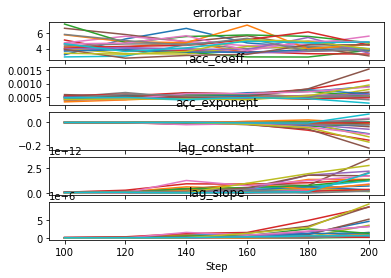

In [43]:
#all parameters per iter
ensemble=newmcmc.samples[int(initmodel/newmcmc.thin_by-1)::stepEnsemble,:,:]
print(ensemble.shape)

xaxis=np.arange(initmodel,newmcmc.totalSteps+1,stepEnsemble*newmcmc.thin_by)
print(xaxis)
nmodels=len(xaxis)
print(nmodels)

for i in np.arange(1,numparams+1):
    plt.subplot(numparams,1,i)
    plt.plot(xaxis,ensemble[:,:,i-1])
    plt.title(paramsList[i-1])
plt.xlabel('Step')

#create folder for saving figure
if not os.path.exists(newmcmc.directory+'figures/'+'paramsIter/'):
    os.makedirs(newmcmc.directory+'figures/'+'paramsIter/')
    
plt.savefig(newmcmc.directory+'figures/'+'paramsIter/'
            +newmcmc.modelName+'_'+str(newmcmc.maxSteps)+'.pdf',
            facecolor='w',pad_inches=0.1)

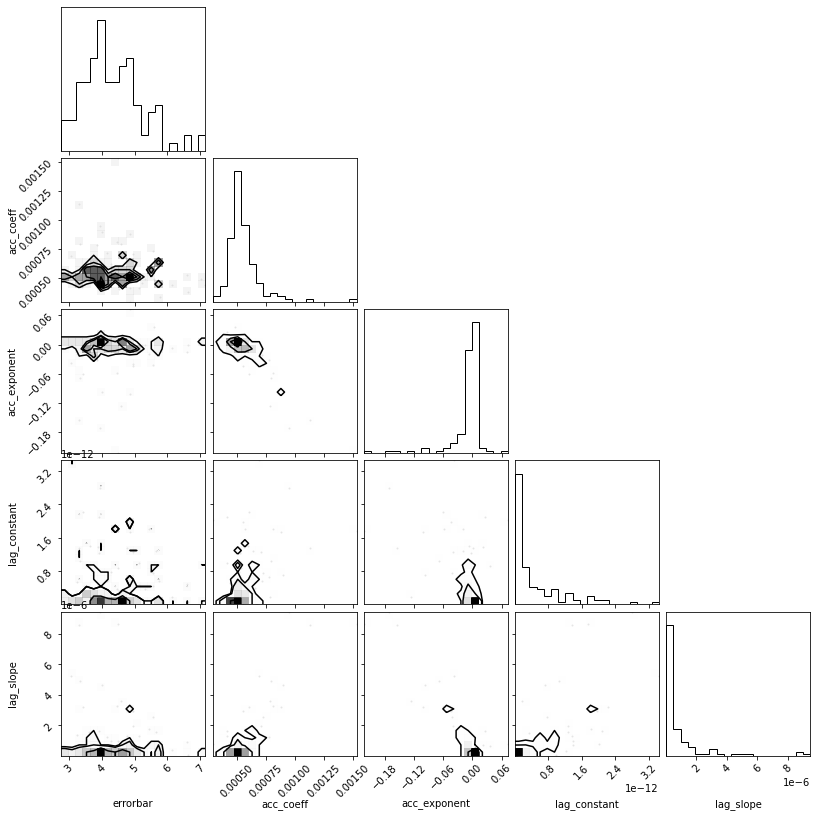

In [44]:
#corner plot with parameter distributions

#reshape ensemble
ensemble2d=ensemble.reshape((newmcmc.nwalkers*nmodels,numparams))
#plot
fig=corner.corner(ensemble2d,labels=paramsList)

#create folder for saving figure
if not os.path.exists(newmcmc.directory+'figures/'+'corner/'):
    os.makedirs(newmcmc.directory+'figures/'+'corner/')
    
plt.savefig(newmcmc.directory+'figures/'+'corner/'
            +newmcmc.modelName+'_'+str(newmcmc.maxSteps)+'.pdf',
            facecolor='w',pad_inches=0.1)

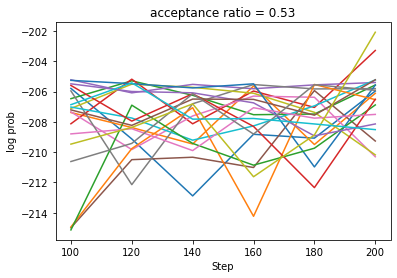

In [62]:
#log prob
logprob=newmcmc.logprob[int(initmodel/newmcmc.thin_by-1)::stepEnsemble,:]

plt.figure()
plt.plot(xaxis,logprob)
plt.title(label='acceptance ratio = '+ str(np.round(np.mean(newmcmc.accFraction),2)))
plt.xlabel('Step')
plt.ylabel('log prob')


#create folder for saving figure
if not os.path.exists(newmcmc.directory+'figures/'+'logprob/'):
    os.makedirs(newmcmc.directory+'figures/'+'logprob/')
    
plt.savefig(newmcmc.directory+'figures/'+'logprob/'
            +newmcmc.modelName+'_'+str(newmcmc.maxSteps)+'.pdf',
            facecolor='w',pad_inches=0.1)

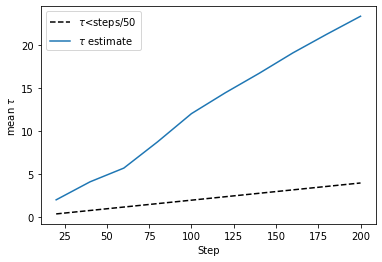

In [48]:
#autocorrelation values
autoxaxis=(newmcmc.maxSteps/10)*np.arange(1,11)
autoxaxis=autoxaxis[:len(newmcmc.autocorr)]

plt.plot(autoxaxis,autoxaxis/50,"--k",label=r'$\tau$<steps/50 ')
plt.plot(autoxaxis,newmcmc.autocorr,label=r'$\tau$ estimate')
plt.xlabel('Step')
plt.ylabel(r'mean $\tau$')
ax=plt.gca()
ax.legend()

#create folder for saving figure
if not os.path.exists(newmcmc.directory+'figures/'+'autocorr/'):
    os.makedirs(newmcmc.directory+'figures/'+'autocorr/')
    
plt.savefig(newmcmc.directory+'figures/'+'autocorr/'
            +newmcmc.modelName+'_'+str(newmcmc.maxSteps)+'.pdf',
            facecolor='w',pad_inches=0.1)

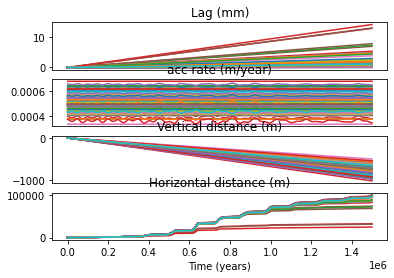

In [49]:
#lag, acc rate and y per time for each model 
#indxlagparams=paramsList.index(lagparamsList[0])

lagt=np.zeros((nmodels*newmcmc.nwalkers,len(times)))
acct=np.zeros((nmodels*newmcmc.nwalkers,len(times)))
tmpt=np.zeros((nmodels*newmcmc.nwalkers,len(times),2))

indxw=0
for w in range(0,newmcmc.nwalkers):
    for i in range(0,nmodels):
            iparams=dict(zip(newmcmc.tr.all_parameter_names,ensemble[i,w,:]))
            newmcmc.tr.set_model(iparams)

            lagti=newmcmc.tr.lagModel.get_lag_at_t(times)
            accti=newmcmc.tr.accuModel.get_accumulation_at_t(times)
            tmpti=np.array(newmcmc.tr.get_trajectory(times))
            
            lagt[indxw]=lagti
            acct[indxw]=accti
            tmpt[indxw,:,:]=tmpti.T
            indxw=indxw+1

#plot lagt
plt.subplot(4,1,1)
plt.plot(times,lagt.T)
plt.xticks([], [])
plt.title('Lag (mm)')

#plot lagt
plt.subplot(4,1,2)
plt.plot(times,acct.T)
plt.xticks([], [])
plt.title('acc rate (m/year)')

#plot yt
plt.subplot(4,1,3)
plt.plot(times,tmpt[:,:,1].T)
plt.title('Vertical distance (m)')
plt.xticks([], [])

#plot xt
plt.subplot(4,1,4)
plt.plot(times,tmpt[:,:,0].T)
plt.xlabel('Time (years)')
plt.title('Horizontal distance (m)')

#create folder for saving figure
if not os.path.exists(newmcmc.directory+'figures/'+'lagaccdist/'):
    os.makedirs(newmcmc.directory+'figures/'+'lagaccdist/')
    
plt.savefig(newmcmc.directory+'figures/'+'lagaccdist/'
            +newmcmc.modelName+'_'+str(newmcmc.maxSteps)+'.pdf',
            facecolor='w',pad_inches=0.1)

118


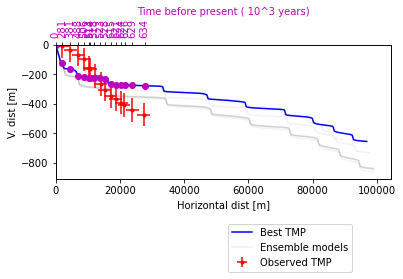

In [50]:
# tmp for opt params, params with highest log prob and 100 random models in ensemble
#reshape logprob
logprob1d=logprob.reshape(nmodels*newmcmc.nwalkers,1)
#best model params
bestTMPindx=np.argmax(logprob1d)

print(bestTMPindx)

bestTMP=tmpt[bestTMPindx,:,:]
plt.plot(bestTMP[:,0],bestTMP[:,1],c='b',label='Best TMP')

#get errorbar of best tmp
errorbar1d=ensemble[:,:,0].reshape(nmodels*newmcmc.nwalkers,1)
bestErrorbar=errorbar1d[bestTMPindx]

ratioyx=0.4;

#find nearest points
ndata=len(newmcmc.xdata)
x_model=bestTMP[:,0]
y_model=bestTMP[:,1]
xnear = np.zeros_like(newmcmc.xdata)
ynear = np.zeros_like(newmcmc.ydata)
timenear = np.zeros_like(newmcmc.xdata)

for i, (xdi, ydi) in enumerate(zip(newmcmc.xdata, newmcmc.ydata)):
    dist = newmcmc.tr._L2_distance(x_model, xdi, y_model, ydi)
    ind = np.argmin(dist)
    xnear[i] = x_model[ind]
    ynear[i] = y_model[ind]
    timenear[i] = times[ind]
    
#plot tmp data assuming errorbar is last errorbar of mcmc
xerr, yerr = bestErrorbar*newmcmc.tr.meters_per_pixel
plt.errorbar(x=newmcmc.xdata, xerr=xerr, y=newmcmc.ydata, yerr=yerr, 
             c='r', marker='.', ls='',label='Observed TMP')

for i in range(nmodels):
    indx=np.random.randint(0,nmodels*newmcmc.nwalkers)
    plt.plot(tmpt[indx,:,0],tmpt[indx,:,1],c="gray", alpha=0.1, zorder=-1)
plt.plot(tmpt[indx,:,0],tmpt[indx,:,1],c="gray", alpha=0.1, zorder=-1,label='Ensemble models')
plt.xlabel("Horizontal dist [m]")
plt.ylabel("V. dist [m]")
ax=plt.gca()
ax.legend(bbox_to_anchor=(0.5, -0.3), loc='upper left')
ymin,ymax=ax.get_ylim()
xmin,xmax=ax.get_xlim()
ax.set_ylim(ymin,0)
ax.set_xlim(0,xmax)
ax.set_box_aspect(ratioyx)

#plot times on right axis
ax2=ax.twiny()
color='m'
ax2.set_xlabel('Time before present ( 10^3 years)',color=color)
plt.scatter(xnear,ynear,marker="o",color='m')
ax2.set_ylim(ymin,0)
ax2.set_xlim(0,xmax)
ax2.tick_params(axis='x',labelcolor=color)
plt.xticks(xnear,np.round(timenear/1000).astype(int),rotation=90)
ax2.set_box_aspect(ratioyx)

#create folder for saving figure
if not os.path.exists(newmcmc.directory+'figures/'+'tmp/'):
    os.makedirs(newmcmc.directory+'figures/'+'tmp/')
    
plt.savefig(newmcmc.directory+'figures/'+'tmp/'
            +newmcmc.modelName+'_'+str(newmcmc.maxSteps)+'.pdf',
            facecolor='w',pad_inches=0.1)
